## Outline 

1. Data set and task
2. Data processing of XML files
3. Why we need encoder decoder architecture
4. Basic GRU based encoder decoder
5. Adding attention
6. Evaluation 
7. Exercise

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import re
import xml.etree.ElementTree as ET

import string

device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, clear_output

import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. Data Management

### 1.1 Alphabet Setup

In [4]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char:0}
for i,alphabet in enumerate(eng_alphabets):
  eng_alpha2index[alphabet] = i+1
print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [5]:
# Hinid unicode Hex range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari
hindi_alphabets = [chr(alpha) for alpha in range(2304,2432)]

hindi_index2alpha = {0:pad_char}
for i,alphabet in enumerate(hindi_alphabets):
  hindi_index2alpha[i+1] = alphabet
print(hindi_index2alpha)

hind_alpha2index = {pad_char:0}
for i,alphabet in enumerate(hindi_alphabets):
  hind_alpha2index[alphabet] = i+1
print(hind_alpha2index)

{0: '-PAD-', 1: 'ऀ', 2: 'ँ', 3: 'ं', 4: 'ः', 5: 'ऄ', 6: 'अ', 7: 'आ', 8: 'इ', 9: 'ई', 10: 'उ', 11: 'ऊ', 12: 'ऋ', 13: 'ऌ', 14: 'ऍ', 15: 'ऎ', 16: 'ए', 17: 'ऐ', 18: 'ऑ', 19: 'ऒ', 20: 'ओ', 21: 'औ', 22: 'क', 23: 'ख', 24: 'ग', 25: 'घ', 26: 'ङ', 27: 'च', 28: 'छ', 29: 'ज', 30: 'झ', 31: 'ञ', 32: 'ट', 33: 'ठ', 34: 'ड', 35: 'ढ', 36: 'ण', 37: 'त', 38: 'थ', 39: 'द', 40: 'ध', 41: 'न', 42: 'ऩ', 43: 'प', 44: 'फ', 45: 'ब', 46: 'भ', 47: 'म', 48: 'य', 49: 'र', 50: 'ऱ', 51: 'ल', 52: 'ळ', 53: 'ऴ', 54: 'व', 55: 'श', 56: 'ष', 57: 'स', 58: 'ह', 59: 'ऺ', 60: 'ऻ', 61: '़', 62: 'ऽ', 63: 'ा', 64: 'ि', 65: 'ी', 66: 'ु', 67: 'ू', 68: 'ृ', 69: 'ॄ', 70: 'ॅ', 71: 'ॆ', 72: 'े', 73: 'ै', 74: 'ॉ', 75: 'ॊ', 76: 'ो', 77: 'ौ', 78: '्', 79: 'ॎ', 80: 'ॏ', 81: 'ॐ', 82: '॑', 83: '॒', 84: '॓', 85: '॔', 86: 'ॕ', 87: 'ॖ', 88: 'ॗ', 89: 'क़', 90: 'ख़', 91: 'ग़', 92: 'ज़', 93: 'ड़', 94: 'ढ़', 95: 'फ़', 96: 'य़', 97: 'ॠ', 98: 'ॡ', 99: 'ॢ', 100: 'ॣ', 101: '।', 102: '॥', 103: '०', 104: '१', 105: '२', 106: '३', 107: '४', 108: '५', 109: '६', 110: 

### 1.2 Helper functions for data processing

In [0]:
train_xml = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/14. Encoder Decoder Models, Attention/Data/training_set_ENG_2_HIN.xml'
test_xml = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/14. Encoder Decoder Models, Attention/Data/test_set_ENG_2_HIN.xml'

In [7]:
# cleaning the text first

regex = re.compile('[^a-zA-Z ]')
def cleanEngVocab(line):
  line = line.replace('-',' ').replace(',',' ').upper()
  line = regex.sub('',line).upper()
  return line.split()

print(cleanEngVocab('EK DIN ACHANAK'))

def cleanHindiVocab(line):
  line = line.replace('-',' ').replace(',',' ')
  cleaned_line = ''
  for char in line:
    if char in hindi_alphabets or char == ' ':
      cleaned_line += char
   
  return cleaned_line.split()

print(cleanHindiVocab('एक दिन अचानक'))

['EK', 'DIN', 'ACHANAK']
['एक', 'दिन', 'अचानक']


### 1.3 Dataset Loading

In [0]:
class Transliteration_DataLoader(Dataset):
  def __init__(self, filename, verbose=False):
    self.eng_words, self.hindi_words = self.read_xml_file(filename,verbose=verbose)
    self.shuffle_indices = list(range(len(self.eng_words)))
    random.shuffle(self.shuffle_indices)
    self.shuffle_start_index = 0
    
  def __len__(self):
    return len(self.eng_words)
    
  def __getitem__(self,idx):
    return self.eng_words[idx], self.hindi_words[idx]
    
  def read_xml_file(self, xml_file, verbose=False):
    lang1 = []
    lang2 = []
    count = 1
    for line in ET.parse(xml_file).getroot():
      eng_word, hindi_word = cleanEngVocab(line[0].text), cleanHindiVocab(line[1].text)
      if len(eng_word) != len(hindi_word):
        if verbose:
          print(count,'Skipping', eng_word, '-',hindi_word)
          count +=1 
        continue
      
      # storing one word by word data and label in a list
      for word1 in eng_word:
        lang1.append(word1)
        
      for word2 in hindi_word:
        lang2.append(word2)
      
    return lang1, lang2
 
  def get_random_sample(self):
    return self.__getitem__(np.random.randint(len(self.eng_words)))
 
  def get_batch_from_array(self,batch_size):
    
    random.shuffle(self.shuffle_indices)
    indices = self.shuffle_indices[0:batch_size]
    
    eng_batch = [self.eng_words[x] for x in indices]
    hindi_batch = [self.hindi_words[x] for x in indices]
    
    return eng_batch,hindi_batch

In [9]:
dataset = Transliteration_DataLoader(train_xml, verbose=True)

1 Skipping ['BARHARWA', 'JUNCTION'] - ['बरहरवा']
2 Skipping ['STATE', 'BNK', 'TR'] - ['स्टेट', 'बैंक', 'ऑफ', 'त्रावणकोर']
3 Skipping ['SOUTH', 'ARLINGTON', 'CHURCH', 'OF', 'CHRIST'] - ['साउथ', 'अर्लिंग्टन']
4 Skipping ['KING', 'EDWARD', 'VII'] - ['किंग', 'एडवर्ड']
5 Skipping ['DIBANG', 'VALLEY'] - ['दिबंगवैली']
6 Skipping ['ORDER', 'OF', 'VASA'] - ['ऑडर', 'ऑफ़', 'द', 'वासा']
7 Skipping ['AZAMNAGAR', 'ROAD'] - ['आज़मनगर']
8 Skipping ['CAPE', 'TOWN'] - ['केपटाउन']
9 Skipping ['NEW', 'ZEALAND'] - ['न्यूज़ीलैंड']
10 Skipping ['SEA', 'OF', 'THE', 'HEBRIDES'] - ['सी', 'ऑफ', 'हरब्रिड्स']
11 Skipping ['RAMCOIND'] - ['राम्को', 'इंड']
12 Skipping ['KELVINGROVE', 'ART', 'GALLERY', 'AND', 'MUSEUM'] - ['केल्विनग्रोव', 'आर्ट', 'एण्ड', 'म्युज़ियम']
13 Skipping ['AUSTRALIAN', 'NATIONAL', 'UNIVERSITY'] - ['ऑस्ट्रेलियननेशनल', 'यूनिवर्सिटी']
14 Skipping ['JAHAN', 'AARA'] - ['जहाँआरा']
15 Skipping ['NAVABHARAT', 'FERRO', 'ALLOYS'] - ['नव', 'भारत', 'फ़ैरो', 'अलॉय']
16 Skipping ['RAMA', 'LINGESHWARA'] - ['रामा

In [10]:
eng_batch, hindi_batch = dataset.get_batch_from_array(5)
for eng,hindi in zip(eng_batch,hindi_batch):
  print(eng,'->',hindi)  

AJRADAAH -> अजरदाह
SESA -> सेसा
GOVINDPURI -> गोविंदपुरी
RAAJAMUNI -> राजमुनि
BIJAULI -> बिजौली


## 2. Encoding the words

In [11]:
word = 'KAVYAJEET'
def word_rep(word, device='cpu'):
  tensor = torch.zeros(len(word)+1,1,len(eng_alpha2index)).to(device)
  for pos, letter in enumerate(word):
    letter_index = eng_alpha2index[letter]
    tensor[pos][0][letter_index] = 1 
  tensor[pos+1][0][eng_alpha2index[pad_char]] = 1

  return tensor

word_rep(word).size()

torch.Size([10, 1, 27])

In [12]:
def gt_rep(word, device='cpu'):
  tensor = torch.zeros(len(word)+1,1).to(device)
  for pos, letter in enumerate(word):
    tensor[pos] = hind_alpha2index[letter]
  return tensor

print(gt_rep('शिविका'))

tensor([[55.],
        [64.],
        [54.],
        [64.],
        [22.],
        [63.],
        [ 0.]])


In [0]:
def padding(names):
  max_word = np.max([len(name) for name in names])
  encoding  = torch.zeros(size=(max_word,len(names),len(eng_alpha2index)))
  for i,name in enumerate(names):
    for n,letter in enumerate(name):
      try:
        index = eng_alpha2index[letter]
      except:
        print(letter)
      encoding[n][i][index] = 1
  return encoding  
  
def batch_seq_data(names,labels):
  padded_encoding = padding(names)
  encoded_labels = [gt_rep(label) for label in labels]
  return padded_encoding, encoded_labels

In [14]:
names = []
labels = []
for i in range(10):
  eng,hindi = dataset.get_random_sample()
  names.append(eng), labels.append(hindi)
  print(eng,'-',hindi)

SAJJAD - सज्जाद
PAMPA - पैम्पा
RAFIQUE - रफीक
PUJA - पूजा
SINGH - सिंह
HUMSAFAR - हमसफर
BAKARAH - बकराह
PREMANAND - प्रेमानन्द
ABHYANKAR - अभयंकर
HANS - हंस


In [15]:
padded_encoding, encoded_labels = batch_seq_data(names,labels)
print('Names')
print(names)
print('\nNames encoding sizes')
print(padding(names).size())
print('-'*60,'\n')
print('Hindi Labels')
print(labels)
print('Hindi label encoding')
print([label.size() for label in encoded_labels])
print(encoded_labels[0])

Names
['SAJJAD', 'PAMPA', 'RAFIQUE', 'PUJA', 'SINGH', 'HUMSAFAR', 'BAKARAH', 'PREMANAND', 'ABHYANKAR', 'HANS']

Names encoding sizes
torch.Size([9, 10, 27])
------------------------------------------------------------ 

Hindi Labels
['सज्जाद', 'पैम्पा', 'रफीक', 'पूजा', 'सिंह', 'हमसफर', 'बकराह', 'प्रेमानन्द', 'अभयंकर', 'हंस']
Hindi label encoding
[torch.Size([7, 1]), torch.Size([7, 1]), torch.Size([5, 1]), torch.Size([5, 1]), torch.Size([5, 1]), torch.Size([6, 1]), torch.Size([6, 1]), torch.Size([11, 1]), torch.Size([7, 1]), torch.Size([4, 1])]
tensor([[57.],
        [29.],
        [78.],
        [29.],
        [63.],
        [39.],
        [ 0.]])


In [16]:
packed_inputs = torch.nn.utils.rnn.pack_padded_sequence(padded_encoding, [len(x) for x in names], enforce_sorted=False)
packed_inputs

PackedSequence(data=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), batch_sizes=tensor([10, 10, 10, 10,  8,  6,  5,  3,  2]), sorted_indices=tensor([7, 8, 5, 2, 6, 0, 1, 4, 3, 9]), unsorted_indices=tensor([5, 6, 3, 8, 7, 2, 4, 0, 1, 9]))

## 3. Network Architecture

### 3.1 Encoder Decoder Model

**note:** without attention model

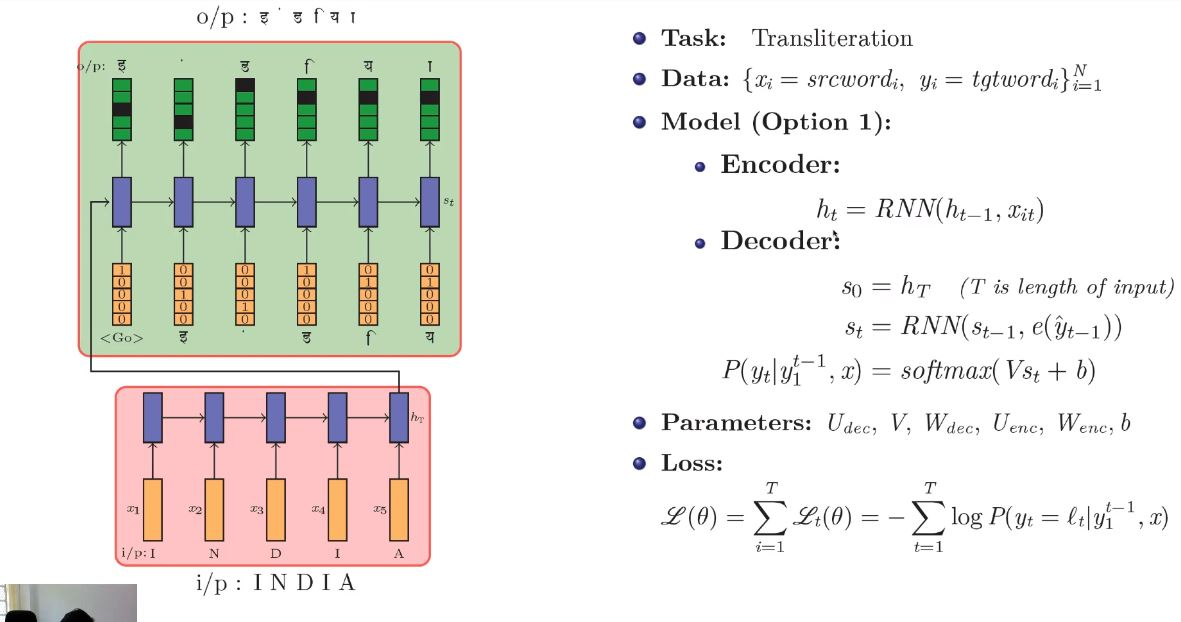

In [17]:
Image(filename = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/14. Encoder Decoder Models, Attention/Data/Transliteration - encoder&decoder.JPG',width=900, height=500)

In [18]:
word = 'INDIA'
word_tensor = word_rep(word)

verbose = False

print('Word:',word)
print('Word representation ->',word_tensor.size())
print('-'*20)
# encoder model
input_size = 27
hidden_size = 256

encoder = nn.GRU(input_size,hidden_size)
encoder_out, encoder_hidden = encoder(packed_inputs)
print(encoder_hidden.size())

Word: INDIA
Word representation -> torch.Size([6, 1, 27])
--------------------
torch.Size([1, 10, 256])


#### 3.1.1 Manual Computation

In [19]:
word = 'INDIA'
word_tensor = packed_inputs

# models 
# encoder model
input_size = 27
hidden_size = 256
output_size = 129
encoder = nn.GRU(input_size,hidden_size)

# decoder model
decoder = nn.GRU(output_size, hidden_size)

# FORWARD PASS encoder
encoder_out, encoder_hidden = encoder(packed_inputs)
print('Encoder hidden Size',encoder_hidden.size())
packed_seq, batch_sizes, sorted_indices, unsorted_indices = encoder_out
print('Encoder out Size',packed_seq.size())


# decoder_input = torch.zeros(1,1,output_size)
# outputs = []

# print('Decoder State', decoder_state.shape)
# print('Decoder input', decoder_input.shape)

# Forward Pass Decoder
#out, decoder_state = decoder(decoder_input, encoder_out)

# for i in range(30):
#   out, decoder_state = decoderl(decoder_input, decoder_state)

#   if self.verbose:
#     print('Decoder intermidiate ouput', out.shape)

#   out = self.h2o(decoder_state)
#   out = self.softmax(out)
#   outputs.append(out.view(1,-1))
  

Encoder hidden Size torch.Size([1, 10, 256])
Encoder out Size torch.Size([64, 256])


In [0]:
packed_inputs[0].size()

In [0]:
print('Length of the batch:', len(names))
max_length = np.max([len(x) for x in names])
print('Maximum length of the word in the batch:',max_length)

In [0]:
word = 'INDIA'
word_tensor = word_rep(word)

# models 
# encoder model
input_size = 27
hidden_size = 256
output_size = 129
encoder = nn.GRU(input_size,hidden_size)

## adding packing 
encoder_out_packed, encoder_hidden_packed = encoder(packed_inputs)
print('Encoder packed hidden Size',encoder_hidden_packed)
print('Encoder packed out Size',encoder_out_packed)
# packed outputs is a packed sequence containing all hidden states
outputs, _ = nn.utils.rnn.pad_packed_sequence(encoder_out_packed)
print(outputs.size())
# FORWARD PASS encoder
encoder_out, encoder_hidden = encoder(word_tensor)
print('Encoder hidden Size',encoder_hidden.size())
print('Encoder out Size',encoder_out.size())

# decoder model
decoder = nn.GRU(output_size, hidden_size)

decoder_state = encoder_hidden
decoder_input = torch.zeros(1,1,output_size)
## here pack the outputs of the data as well to feed it to the decoder as packed

outputs = []

print('Decoder State', decoder_state.shape)
print('Decoder input', decoder_input.shape)


for i in range(30):
  decoder_out, decoder_state = decoder(decoder_input, decoder_state)
  
  
print('Decoder output size',decoder_out.size())
print('Decoder state size', decoder_state.size())

#### 3.1.2 Class for encoder decoder model without attention

In [0]:
MAX_OUTPUT_CHARS = 30

class Transliteration_EncoderDecoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, verbose=False):
    super(Transliteration_EncoderDecoder, self).__init__()
    
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    self.encoder_rnn_cell = nn.GRU(input_size,hidden_size)
    self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)
    
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    self.verbose = verbose
    
  def forward(self, input_, max_output_chars = MAX_OUTPUT_CHARS, device='cpu',ground_truth = None):
    
    # encoder forward pass
    out, hidden = self.encoder_rnn_cell(input_)
    # the input is of size (N,1,27)
    # when feeded in the GRU it will automatically calculate the ouput
    # of each individual characters
            
    # decoder
    decoder_state = hidden # setting the cell state of decoder = hidden state of encoder
    decoder_input = torch.zeros(1,1,self.output_size).to(device)
    outputs = []
    
    if self.verbose:
      print('Decoder State', decoder_state.shape)
      print('Decoder input', decoder_input.shape)
      
    for i in range(max_output_chars):
      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
      
      if self.verbose:
        print('Decoder intermidiate ouput', out.shape)
      
      out = self.h2o(decoder_state)
      out = self.softmax(out)
      outputs.append(out.view(1,-1))
      
      if self.verbose:
        print('decoder output', out.shape)
        self.verbose = False
        
      ## Accelerate training using teacher forcing technique
      max_idx = torch.argmax(out,2, keepdim=True)
      if ground_truth is not None:
        max_idx = ground_truth[i].view(1,1,1)
      # making the output as input for the next cell in one-hot encoded form
      one_hot = torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,max_idx,1)  
      decoder_input = one_hot.detach()
    
    return outputs

### 3.2 Encoder decoder model wtih attention


1. The basic idea is to feed some of the input to the decoder from the encoder model
2. Attention is to place more weight or emphasis on the word in the sentence before feeding it to decoder
3. Feeding weighted sum of the input vectors from the encoder to the decoder
4. Weights are the new parameters for the attention model and model will learn from the data


Model - 
- The encoder consist of a RNN architecture
- It encodes the input into tensors

In [0]:
Image(filename = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/14. Encoder Decoder Models, Attention/Data/Encoder&decoder with Attention.JPG',width=900, height=500)

#### 3.2.1 Manual computation with attention

In [0]:
input_ = 'INDIA'
input_ = word_rep(input_)
print(input_.size())
hidden_size = 256

# defining the terms
U_att = nn.Linear(hidden_size,hidden_size)
W_att = nn.Linear(hidden_size, hidden_size)
V_att = nn.Linear(hidden_size,1)

# encoder model
encoder = nn.GRU(len(eng_alpha2index),hidden_size)

encoder_output, hidden = encoder(input_)
print('Original Encoder Ouput',encoder_output.size())
encoder_output = encoder_output.view(-1,hidden_size)
print('Encoder output',encoder_output.size(), 'Hidden output',hidden.size())

print()
print('Decoder Model\n','--'*20)

# decoder model 

decoder = nn.GRU(hidden_size*2,hidden_size)
outputs = []
labels = 'इंडिया'
output_size = len(hind_alpha2index)
decoder_input2hidden = nn.Linear(output_size, hidden_size)
h2o = nn.Linear(hidden_size,output_size)
softmax =  nn.Softmax(dim=2)

decoder_input = torch.zeros(1,1,output_size)
decoder_state = hidden
U = U_att(encoder_output)
print('U',U.size())

for label in labels:
  # Attention comes here 
  print('Original decoder\'s hidden size',decoder_state.size())
  W = W_att(decoder_state.view(1,-1).repeat(encoder_output.shape[0],1))  
  print(label,'->','| Encoder Output',encoder_output.size(), '| Hidden',decoder_state.size(), '| W',W.size())
  
  V = V_att(torch.tanh(U+W))
  print('V',V.size())
  
  att_weights = F.softmax(V.view(1,-1),dim=1)
  print('Attention Weights',att_weights.size())
  print('Encoder Outputs',encoder_output.size())

  # combining the attention weigths with encoder outputs
  C = torch.bmm(att_weights.unsqueeze(0), encoder_output.unsqueeze(0))
  print('C ->',C.size())
  
  # Performs a batch matrix-matrix product of matrices stored in batch1 and batch2.
  
  embedding = decoder_input2hidden(decoder_input)
  print('Linear Transformation of decoder_input',decoder_input.size(),'to',embedding.size())
  # concatenation of the decoder input and the attention weigths
  decoder_input = torch.cat((embedding.squeeze(0),C.squeeze(0)),dim=1).unsqueeze(1)
  print('Decoder_input ->',decoder_input.size())
  
  out, decoder_state = decoder(decoder_input, decoder_state)
  print('Decoder out:',out.size(), 'decoder state', decoder_state.size())
  ## feed forward to the output via neural network
  out = h2o(decoder_state)
  out = softmax(out)
  outputs.append(out.view(1,-1))
  print('Feed Forward network output',out.size())
  # now create the one hot encoded input for the next word/letter
  max_idx = torch.argmax(out,dim=2,keepdim=True)
  
  print('-'*20)
  break

**Batch Matrix Matrix Multiplication**

https://stackoverflow.com/questions/50826644/why-do-we-do-batch-matrix-matrix-product

#### 3.2.2 Class for Encoder Decoder Model with Attention

In [0]:
class Transliteration_EncoderDecoder_with_attention(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, verbose=False):
    super(Transliteration_EncoderDecoder_with_attention, self).__init__()
    
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    self.encoder_rnn_cell = nn.GRU(input_size,hidden_size)
    self.out2hidden = nn.Linear(output_size,hidden_size)
    self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
    
    ## Additional Parameters for attention
    self.V_att = nn.Linear(hidden_size,1)
    self.U_att = nn.Linear(hidden_size, hidden_size)
    self.W_att = nn.Linear(hidden_size,hidden_size)
        
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    self.verbose = verbose
    
  def forward(self, input_, max_output_chars = MAX_OUTPUT_CHARS, device='cpu',ground_truth = None):
    
    # encoder forward pass
    encoder_output, encoder_state = self.encoder_rnn_cell(input_)
    encoder_output = encoder_output.view(-1,self.hidden_size)
    U = self.U_att(encoder_output)
    
    if self.verbose:
      print('Encoder Input', input_.shape)
      print('Encoder Ouput', encoder_output.shape)
      print('Encoder State', encoder_state.shape)
      print('U',U.size())
      print()
      
    # decoder
    decoder_state = encoder_state # setting the cell state of decoder = hidden state of encoder
    decoder_input = torch.zeros(1,1,self.output_size).to(device)
    outputs = []
         
    for i in range(max_output_chars):
      
      # attention computation
      W = self.W_att(decoder_state.view(1,-1).repeat(encoder_output.shape[0],1)) 
      V = self.V_att(torch.tanh(U+W))        
      att_weights = F.softmax(V.view(1,-1),dim=1)
      C = torch.bmm(att_weights.unsqueeze(0), encoder_output.unsqueeze(0))
        
      if self.verbose:
        print('Attention Weights ',att_weights.size())
        print('Attention batch multiplied Matrix',C.size())
        print('Decoder original Input',decoder_input.size())
        
        print()
      
      embedding = self.out2hidden(decoder_input) # Transforming the given decoder inputs to hidden size
      decoder_input = torch.cat((embedding.squeeze(0),C.squeeze(0)),dim=1).unsqueeze(1)
      
      if self.verbose:
        print('Embedding Transformation',embedding.size())
        print('Decoder State', decoder_state.shape)
        print('Decoder input', decoder_input.shape)
        print()
      
      out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
      
      if self.verbose:
        print('Decoder intermidiate ouput', out.shape)
        print()
      out = self.h2o(decoder_state)
      out = self.softmax(out)
      outputs.append(out.view(1,-1))
      
      if self.verbose:
        print('decoder output', out.shape)
        print()
        self.verbose = False
        
      ## Accelerate training using teacher forcing technique
      max_idx = torch.argmax(out,2, keepdim=True)
      if ground_truth is not None:
        max_idx = ground_truth[i].long().view(1,1,1)
      # making the output as input for the next cell in one-hot encoded form
      one_hot = torch.FloatTensor(out.shape).to(device)
      one_hot.zero_()
      one_hot.scatter_(2,max_idx,1)  
      decoder_input = one_hot.detach()
    
    return outputs

In [0]:
def infer(model, word, max_output_chars = MAX_OUTPUT_CHARS):
  word_tensor = word_rep(word,device=device)
  outputs = model(word_tensor, max_output_chars = MAX_OUTPUT_CHARS, device=device)
  return outputs


model2 = Transliteration_EncoderDecoder(input_size=len(eng_alpha2index), hidden_size=256, output_size=len(hind_alpha2index),verbose=True)  
model2.to(device)
outputs = infer(model2, 'KAVYAJEET')

In [0]:
## Inference on untrained model
for out in outputs:
  index = torch.argmax(out).item()
  print(out.size(), hindi_alphabets[index])

## 4. Training the models

In [0]:
# train_batch
def train_batch(net,opt,criterion, batch_size, device='cpu', teacher_force=False):
  net.train().to(device)
  opt.zero_grad()
  eng_batch, hindi_batch = dataset.get_batch_with_packing(batch_size)
  total_loss = 0
  
  for eng_word,hindi_word in zip(eng_batch, hindi_batch):
    input_, label = word_rep(eng_word,device=device), gt_rep(hindi_word,device=device)
    outputs = net(input_,max_output_chars=label.shape[0], ground_truth= label if teacher_force else None, device=device)
    
    for i, output in enumerate(outputs):
      loss = criterion(output, label[i].long())/batch_size
      loss.backward(retain_graph=True)
      total_loss += loss
    
  opt.step()
  return total_loss/batch_size

def train_setup(net, lr=0.001, n_batches=100, batch_size=10, device='cpu', display_freq=5):
  
  criterion = nn.NLLLoss(ignore_index = -1)
  opt = optim.Adam(net.parameters(), lr=lr)
  
  teacher_force_upto = n_batches//3
  
  loss_arr = np.zeros(n_batches+1)
  
  for i in range(n_batches):
    teacher_force = i < teacher_force_upto
    loss_arr[i+1] = (loss_arr[i]*i + train_batch(net,opt,criterion, batch_size=batch_size, device=device, teacher_force=teacher_force))/(i + 1)
    
    if i%display_freq == 0:
      clear_output(wait=True)
      print('Iteration',i,'Loss',loss_arr[i])
      plt.figure()
      plt.plot(loss_arr[1:i])
      plt.xlabel('n_batches')
      plt.ylabel('Cross Entropy Loss')
      plt.show()
      print('\n\n')
      
  torch.save(net,'model.pt')
  return loss_arr

### 4.1 Training Encoder Decoder model without Attention

In [0]:
%%time 
model = Transliteration_EncoderDecoder(input_size=len(eng_char2index), hidden_size=256, output_size=len(hind_char2index),verbose=False).to(device)
train_setup(model, n_batches=2000, batch_size=64,device=device, display_freq=10)

RuntimeError: ignored

### 4.2 Training Encoder Decoder model with Attention

Iteration 1995 Loss 0.13741552829742432


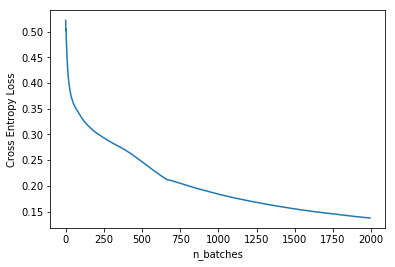




CPU times: user 1h 14min 11s, sys: 3min 38s, total: 1h 17min 49s
Wall time: 1h 16min 30s


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Transliteration_EncoderDecoder_with_attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
%%time
net = Transliteration_EncoderDecoder_with_attention(input_size=len(eng_char2index), hidden_size=256, output_size=len(hind_char2index),verbose=False).to(device)
train_setup(net, n_batches=2000, batch_size=64, device=device)

## 5. Evaluation of the models

In [0]:
def accuracy_per_word(model, device = device, verbose=False):
  test_dataset = Transliteration_DataLoader(test_xml)
  correct_words  = 0
  model.eval()

  for i in range(len(test_dataset)):
    eng_word, hindi_word = test_dataset.__getitem__(i)
    test_input = word_rep(eng_word,device=device)
    label = gt_rep(hindi_word, device=device)
    predictions = model(test_input,device=device)
    string  = ''
    for j,pred in enumerate(predictions):
      max_idx = torch.argmax(pred,dim=1).item()
      string += hind_index2char[max_idx]
    string = string.replace('-PAD-','')  
    if string == hindi_word:
      correct_words += 1
      if verbose:
        print('Eng Word:',eng_word,'| Hidni Word:',hindi_word, '| Prediction',string)

  print(correct_words/len(test_dataset)*100,'%')  
  
  
def accuracy_per_letter(model, device=device, verbose=False):
  test_dataset = Transliteration_DataLoader(test_xml)
  correct_letter  = 0
  total_letter = 0
  for i in range(len(test_dataset)):
    eng_word, hindi_word = test_dataset[i]
    test_input = word_rep(eng_word, device=device)
    labels = gt_rep(hindi_word, device=device)
    predictions = model(test_input, device=device)
    string  = ''
    for j,label in enumerate(labels):
      index = torch.argmax(predictions[j],dim=1)
      total_letter += 1
      if (label.long().item()==index):
        correct_letter += 1

  print(correct_letter/total_letter*100)

In [0]:
print('Encoder Decoder Model without Attention')
accuracy_per_word(model,device=device)
accuracy_per_letter(model,device=device)

print('Encoder Decoder Model with Attention')
accuracy_per_word(net,device=device)
accuracy_per_letter(net,device=device)

Encoder Decoder Model without Attention
14.6 %
60.8274647887324
Encoder Decoder Model with Attention
24.2 %
68.13380281690141
